In [16]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [56]:
# open cleaned_weight_measurements.pkl
with open('cleaned_weight_measurements.pkl', 'rb') as f:
    df = pickle.load(f)

In [57]:
# remove columns 2 to 5
df = df.drop(df.columns[1:5], axis=1)

In [58]:
# is any of the weight values a string?
for col in df.columns[1:]:
    if df[col].dtype == 'object':
        # convert to numeric, forcing errors to NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [59]:
# make all values relative to the second columns, except for the first column
df.iloc[:, 1:] = df.iloc[:, 1:].div(df.iloc[:, 1], axis=0) * 100

In [60]:
# melt the dataframe to have three columns: 'name', 'date', and 'weight'
melted_df = df.melt(id_vars=["Name"], var_name="Date", value_name="weight")
# convert 'Date' to datetime
melted_df['Date'] = pd.to_datetime(melted_df['Date'], format='%Y-%m-%d')
# rename 'Name' to 'subject'
melted_df.rename(columns={'Name': 'subject', "Date": 'date'}, inplace=True)

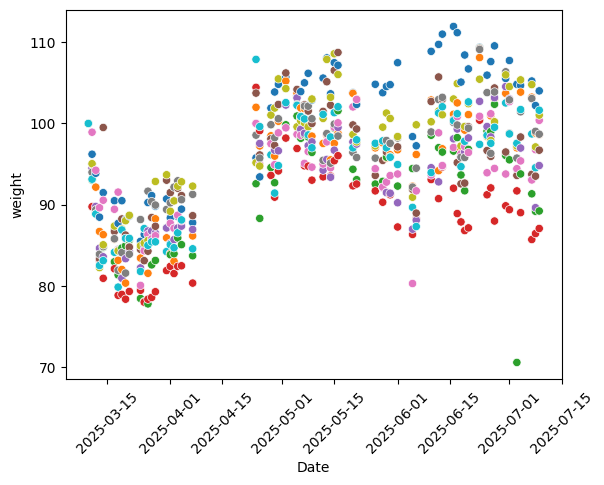

In [61]:
sns.scatterplot(data=melted_df, x='date', y='weight', hue='subject')
plt.xticks(rotation=45)
plt.xlabel('Date')
# remove legend
plt.legend([], [], frameon=False)

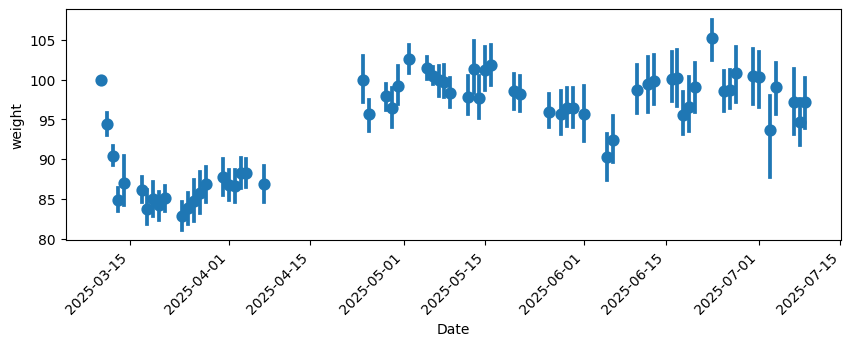

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.pointplot(data=melted_df, x='date', y='weight', native_scale= True, linestyles="")
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')

# save figure as .pdf
plt.savefig('figures/hmv_weight_over_time.pdf', bbox_inches='tight', transparent=True)


/tmp/ipykernel_529895/45403478.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['daily_weight_variation'] = filtered_df.groupby('subject')['weight'].diff()
/tmp/ipykernel_529895/45403478.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['time_diff_days'] = filtered_df.groupby('subject')['date'].diff().dt.days


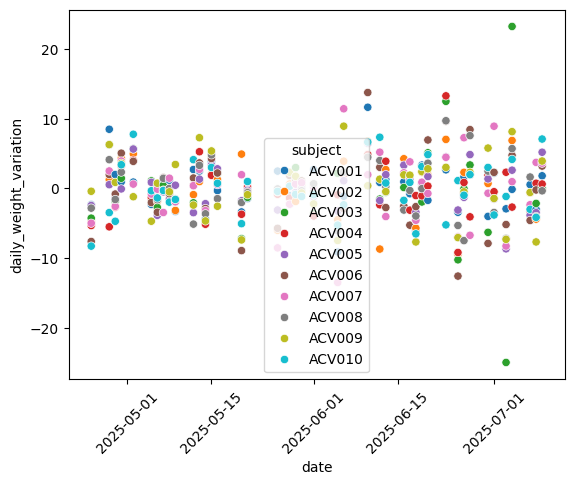

In [63]:
# explore the relationship between how much weight variation has been from day to day, and how much water they drank in the task between these times.
# restrict the analysis to the data from the 15th of march to the 15th of April
start_date = pd.to_datetime('2025-04-15')
end_date = pd.to_datetime('2025-07-15')
filtered_df = melted_df[(melted_df['date'] >= start_date) & (melted_df['date'] <= end_date)]

# calculate the daily weight variation
filtered_df['daily_weight_variation'] = filtered_df.groupby('subject')['weight'].diff()
# calculate the time difference in days
filtered_df['time_diff_days'] = filtered_df.groupby('subject')['date'].diff().dt.days

# # restrict to rows where the time difference is 1 day
# filtered_df = filtered_df[filtered_df['time_diff_days'] == 1]
# # drop nans
# filtered_df = filtered_df.dropna()

# plot the daily weight variation against the date
sns.scatterplot(data=filtered_df, x='date', y='daily_weight_variation', hue='subject')
plt.xticks(rotation=45)
plt.show()

In [64]:
filtered_df

,subject,date,weight,daily_weight_variation,time_diff_days
210,ACV001,2025-04-24,95.758123,NaN,NaN
211,ACV002,2025-04-24,101.991410,NaN,NaN
212,ACV003,2025-04-24,92.572614,NaN,NaN
213,ACV004,2025-04-24,104.450166,NaN,NaN
214,ACV005,2025-04-24,100.000000,NaN,NaN
...,...,...,...,...,...
645,ACV006,2025-07-09,96.707262,3.202526,1.0
646,ACV007,2025-07-09,100.384615,3.615385,1.0
647,ACV008,2025-07-09,98.679612,-0.349515,1.0
648,ACV009,2025-07-09,101.033058,3.925620,1.0


In [33]:
# get data on water consumption
import lecilab_behavior_analysis.utils as utils
import lecilab_behavior_analysis.df_transforms as dft
import lecilab_behavior_analysis.plots as plots
from pathlib import Path
tv_projects = utils.get_server_projects()
animals = utils.get_animals_in_project(tv_projects[1])
animals_to_remove = ['test', 'test2']
animals = [animal for animal in animals if animal not in animals_to_remove]
# retrieve the data for the remaining animals
for mouse in animals:
    local_path = Path(utils.get_outpath()) / Path(tv_projects[1]) / Path("sessions") / Path(mouse)
    # create the directory if it doesn't exist
    local_path.mkdir(parents=True, exist_ok=True)
    # download the session data
    utils.rsync_cluster_data(
        project_name=tv_projects[1],
        file_path="sessions/{}/{}.csv".format(mouse, mouse),
        local_path=str(local_path),
        credentials=utils.get_idibaps_cluster_credentials(),
    )

df_list = []
for mouse in animals:
    local_path = Path(utils.get_outpath()) / Path(tv_projects[1]) / Path("sessions") / Path(mouse)
    andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")
    df_list.append(andf)
    print(f"Loaded data for {mouse}.")
# concatenate the dataframes
behavdf = pd.concat(df_list, ignore_index=True)

receiving incremental file list
ACV001.csv

sent 115,932 bytes  received 1,984,819 bytes  200,071.52 bytes/sec
total size is 285,279,331  speedup is 135.80
receiving incremental file list
ACV002.csv

sent 103,528 bytes  received 862,330 bytes  113,630.35 bytes/sec
total size is 223,944,891  speedup is 231.86
receiving incremental file list
ACV003.csv

sent 107,791 bytes  received 3,004,487 bytes  414,970.40 bytes/sec
total size is 253,792,057  speedup is 81.55
receiving incremental file list
ACV004.csv

sent 95,121 bytes  received 2,035,615 bytes  327,805.54 bytes/sec
total size is 195,952,017  speedup is 91.96
receiving incremental file list
ACV005.csv

sent 92,734 bytes  received 1,518,812 bytes  214,872.80 bytes/sec
total size is 184,006,882  speedup is 114.18
receiving incremental file list
ACV006.csv

sent 95,576 bytes  received 2,602,507 bytes  359,744.40 bytes/sec
total size is 201,312,111  speedup is 74.61
receiving incremental file list
ACV007.csv

sent 96,647 bytes  received 

/tmp/ipykernel_529895/890152333.py:26: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40,48) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV001.


/tmp/ipykernel_529895/890152333.py:26: DtypeWarning: Columns (13,14,27,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV002.


/tmp/ipykernel_529895/890152333.py:26: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40,47) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV003.


/tmp/ipykernel_529895/890152333.py:26: DtypeWarning: Columns (13,14,27,28,29,30,38,39,40,47) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV004.


/tmp/ipykernel_529895/890152333.py:26: DtypeWarning: Columns (13,14,27,28,29,30,38,39,40,47) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV005.


/tmp/ipykernel_529895/890152333.py:26: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40,47) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV006.


/tmp/ipykernel_529895/890152333.py:26: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40,47) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV007.


/tmp/ipykernel_529895/890152333.py:26: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV008.


/tmp/ipykernel_529895/890152333.py:26: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40,47) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV009.


/tmp/ipykernel_529895/890152333.py:26: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV010.


In [66]:
filtered_df

,subject,date,weight,daily_weight_variation,time_diff_days
210,ACV001,2025-04-24,95.758123,NaN,NaN
211,ACV002,2025-04-24,101.991410,NaN,NaN
212,ACV003,2025-04-24,92.572614,NaN,NaN
213,ACV004,2025-04-24,104.450166,NaN,NaN
214,ACV005,2025-04-24,100.000000,NaN,NaN
...,...,...,...,...,...
645,ACV006,2025-07-09,96.707262,3.202526,1.0
646,ACV007,2025-07-09,100.384615,3.615385,1.0
647,ACV008,2025-07-09,98.679612,-0.349515,1.0
648,ACV009,2025-07-09,101.033058,3.925620,1.0


In [68]:
filtered_df['water_consumption'] = np.nan
# calculate the water consumption for each subject for each period, at 9am
for row in filtered_df.itertuples():
    subject = row.subject
    date = row.date
    time_diff_days = row.time_diff_days
    date9am = date.replace(hour=9, minute=0, second=0, microsecond=0)
    # if time_diff_days is NaN, skip this row
    if pd.isna(time_diff_days):
        continue
    previous_date9am = date9am - pd.Timedelta(days=time_diff_days)
    # get the water consumption for the subject on the date
    subject_df = behavdf[behavdf['subject'] == subject]
    # convert date column to datetime
    subject_df['date'] = pd.to_datetime(subject_df['date'], format='%Y-%m-%d %H:%M:%S')
    subject_date_df = subject_df[(subject_df['date'] >= previous_date9am) & (subject_df['date'] < date9am)]
    total_water_consumption = subject_date_df['water'].sum()
    filtered_df.loc[row.Index, 'water_consumption'] = total_water_consumption

/tmp/ipykernel_529895/1515590142.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['water_consumption'] = np.nan
/tmp/ipykernel_529895/1515590142.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject_df['date'] = pd.to_datetime(subject_df['date'], format='%Y-%m-%d %H:%M:%S')
/tmp/ipykernel_529895/1515590142.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [72]:
filtered_df['water_consumption_normalized'] = filtered_df['water_consumption'] / filtered_df['time_diff_days']

/tmp/ipykernel_529895/3054460057.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['water_consumption_normalized'] = filtered_df['water_consumption'] / filtered_df['time_diff_days']


In [138]:
# regress the water consumption against the daily weight variation
import statsmodels.api as sm
X = filtered_df['water_consumption_normalized']
y = filtered_df['daily_weight_variation']
X = sm.add_constant(X)  # add a constant term to the predictor
model = sm.OLS(y, X, missing='drop').fit()  # fit the model, dropping rows with NaN values
print(model.summary())


                              OLS Regression Results                              
Dep. Variable:     daily_weight_variation   R-squared:                       0.129
Model:                                OLS   Adj. R-squared:                  0.127
Method:                     Least Squares   F-statistic:                     61.34
Date:                    Fri, 11 Jul 2025   Prob (F-statistic):           4.09e-14
Time:                            12:30:39   Log-Likelihood:                -1170.6
No. Observations:                     415   AIC:                             2345.
Df Residuals:                         413   BIC:                             2353.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

/tmp/ipykernel_529895/2270795638.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'Coefficients: {model.params[1]:.4f} (water consumption)\n'
/tmp/ipykernel_529895/2270795638.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'Intercept: {model.params[0]:.2f}',


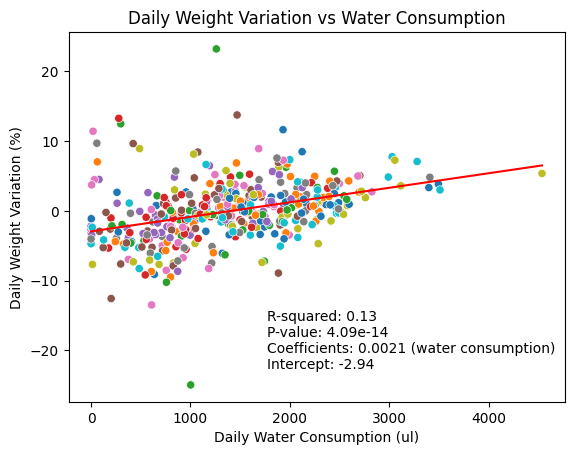

<Figure size 640x480 with 0 Axes>

In [139]:
# plot the correlation between daily weight variation and water consumption
sns.scatterplot(data=filtered_df, x='water_consumption_normalized', y='daily_weight_variation', hue='subject')
# add a regression line using the model in the cell above
x_vals = np.linspace(filtered_df['water_consumption_normalized'].min(), filtered_df['water_consumption_normalized'].max(), 100)
y_vals = model.predict(sm.add_constant(x_vals))
plt.plot(x_vals, y_vals, color='red', label='Regression Line')
# add the statistics to the plot
plt.text(0.4, 0.25, f'R-squared: {model.rsquared:.2f}\n'
                     f'P-value: {model.f_pvalue:.2e}\n'
                     f'Coefficients: {model.params[1]:.4f} (water consumption)\n'
                     f'Intercept: {model.params[0]:.2f}', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
# set labels and title

plt.xlabel('Daily Water Consumption (ul)')
plt.ylabel('Daily Weight Variation (%)')
plt.title('Daily Weight Variation vs Water Consumption')
#remove legend
plt.legend([], [], frameon=False)
plt.show()
# save figure as .pdf
plt.savefig('figures/hmv_daily_weight_vs_water_consumed.pdf', bbox_inches='tight', transparent=True)

In [105]:
# compare with the citric acid consumption data
with open('cleaned_citric_acid_weight.pkl', 'rb') as f:
    df_ca = pickle.load(f)

# group the filtered_df by date
filtered_df_grouped = filtered_df.groupby('date').agg({
    'daily_weight_variation': 'mean',
    'water_consumption': 'sum',
    'time_diff_days': 'mean'
    }).reset_index()

# add the citric acid consumption data to the filtered_df_grouped
# turn the columns of df_ca into a single column
df_ca = df_ca.melt()
df_ca.columns = ['date', 'citric_acid_consumption']
# turn to positive values and add the loss of water when turning the bottle upside down
df_ca['citric_acid_consumption'] = -df_ca['citric_acid_consumption'] - 0.6
df_ca['date'] = pd.to_datetime(df_ca['date'], format='%Y-%m-%d')

# merge the two dataframes on date
df_combined = pd.merge(filtered_df_grouped, df_ca, on='date', how='left')

In [106]:
df_combined['water_consumption_normalized'] = df_combined['water_consumption'] / df_combined['time_diff_days']
df_combined['citric_acid_consumption_normalized'] = df_combined['citric_acid_consumption'] / df_combined['time_diff_days']

<Axes: xlabel='water_consumption_normalized', ylabel='citric_acid_consumption_normalized'>

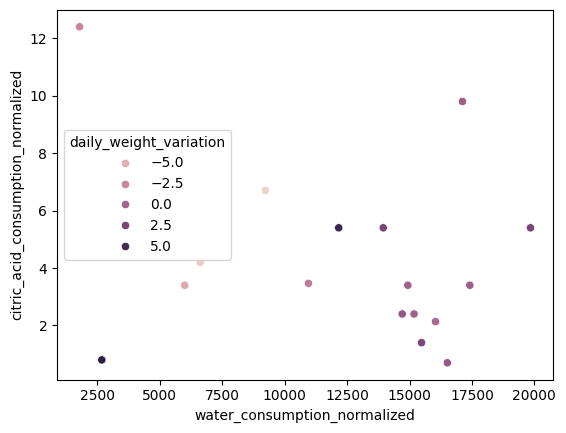

In [107]:
sns.scatterplot(data=df_combined, x='water_consumption_normalized', y='citric_acid_consumption_normalized', hue='daily_weight_variation')

the weird dot in 2500 of water consumption is because the task was stopped that weekend due to TV failure
the animals had normal water during that weekend. It corresponds to the 2025-06-23 date

In [141]:
# remove this point from this dataset and investigate the change of weight when animals have free access to water

dfc_cleaned = df_combined[df_combined.date != pd.to_datetime('2025-06-23')]
dfc_cleaned = dfc_cleaned.dropna(subset=['water_consumption_normalized', 'citric_acid_consumption_normalized'])
dfc_cleaned['water_consumption_normalized'] = dfc_cleaned['water_consumption_normalized'] / 1000 # in mls

# Ensure 'citric_acid_consumption_normalized' is numeric
dfc_cleaned['citric_acid_consumption_normalized'] = pd.to_numeric(dfc_cleaned['citric_acid_consumption_normalized'], errors='coerce')

import statsmodels.api as sm
X = dfc_cleaned['water_consumption_normalized']
y = dfc_cleaned['citric_acid_consumption_normalized']
X = sm.add_constant(X)  # add a constant term to the predictor
model = sm.OLS(y, X, missing='drop').fit()  # fit the model, dropping rows with NaN values
print(model.summary())

                                    OLS Regression Results                                    
Dep. Variable:     citric_acid_consumption_normalized   R-squared:                       0.200
Model:                                            OLS   Adj. R-squared:                  0.143
Method:                                 Least Squares   F-statistic:                     3.496
Date:                                Fri, 11 Jul 2025   Prob (F-statistic):             0.0826
Time:                                        12:31:02   Log-Likelihood:                -38.331
No. Observations:                                  16   AIC:                             80.66
Df Residuals:                                      14   BIC:                             82.21
Df Model:                                           1                                         
Covariance Type:                            nonrobust                                         
                                   coef    std err

/home/hmv/anaconda3/envs/dev/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=16 observations were given.
  return hypotest_fun_in(*args, **kwds)


/tmp/ipykernel_529895/3209468868.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'Coefficients: {model.params[1]:.4f} (water consumption)\n'
/tmp/ipykernel_529895/3209468868.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'Intercept: {model.params[0]:.2f}',


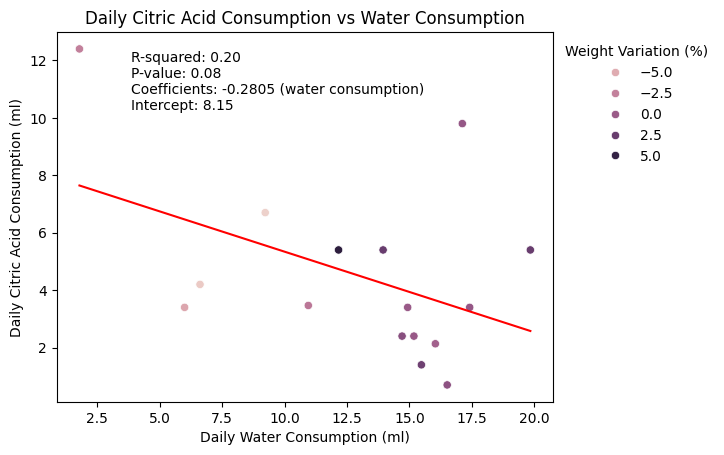

<Figure size 640x480 with 0 Axes>

In [150]:

sns.scatterplot(data=dfc_cleaned, x='water_consumption_normalized', y='citric_acid_consumption_normalized', hue='daily_weight_variation')
# add a regression line using the model in the cell above
x_vals = np.linspace(dfc_cleaned['water_consumption_normalized'].min(), dfc_cleaned['water_consumption_normalized'].max(), 100)
y_vals = model.predict(sm.add_constant(x_vals))
plt.plot(x_vals, y_vals, color='red')
# add the statistics to the plot
plt.text(0.15, 0.95, f'R-squared: {model.rsquared:.2f}\n'
                     f'P-value: {model.f_pvalue:.2f}\n'
                     f'Coefficients: {model.params[1]:.4f} (water consumption)\n'
                     f'Intercept: {model.params[0]:.2f}', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
# set labels and title

plt.xlabel('Daily Water Consumption (ml)')
plt.ylabel('Daily Citric Acid Consumption (ml)')
plt.title('Daily Citric Acid Consumption vs Water Consumption')
#put the legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, title='Weight Variation (%)')
plt.show()
# save figure as .pdf
plt.savefig('figures/hmv_citric_acid_vs_water.pdf', bbox_inches='tight', transparent=True)


(20248.0, 20269.0)

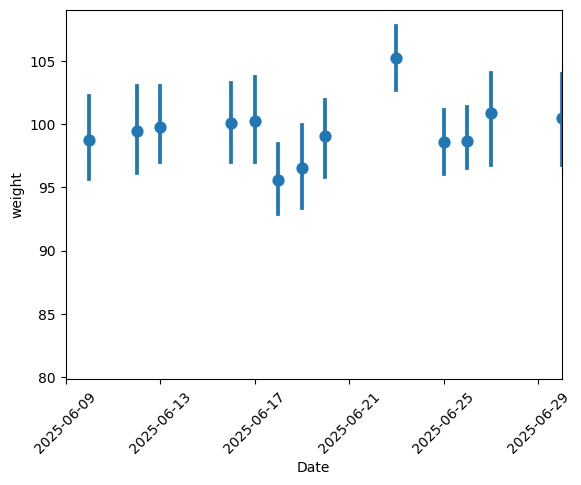

In [130]:
sns.pointplot(data=melted_df, x='date', y='weight', native_scale=True, linestyles="")
plt.xticks(rotation=45)
plt.xlabel('Date')
# remove legend
plt.legend([], [], frameon=False)

plt.xlim(pd.to_datetime('2025-06-09'), pd.to_datetime('2025-06-30'))

### How much weight variation in the previous day determines how much they drink?

In [131]:
# add the previous day's variation to filtered_df
filtered_df['previous_daily_weight_variation'] = np.nan
# calculate the previous day's daily weight variation for each subject
for row in filtered_df.itertuples():
    subject = row.subject
    date = row.date
    # get the previous day's daily weight variation for the subject
    subject_df = filtered_df[filtered_df['subject'] == subject]
    previous_date = date - pd.Timedelta(days=1)
    previous_row = subject_df[subject_df['date'] == previous_date]
    if not previous_row.empty:
        filtered_df.loc[row.Index, 'previous_daily_weight_variation'] = previous_row['daily_weight_variation'].values[0]


/tmp/ipykernel_529895/332081344.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['previous_daily_weight_variation'] = np.nan


In [151]:
# regress the water consumption against the daily weight variation
import statsmodels.api as sm
X = filtered_df['water_consumption_normalized']
y = filtered_df['previous_daily_weight_variation']
X = sm.add_constant(X)  # add a constant term to the predictor
model = sm.OLS(y, X, missing='drop').fit()  # fit the model, dropping rows with NaN values
print(model.summary())

                                   OLS Regression Results                                  
Dep. Variable:     previous_daily_weight_variation   R-squared:                       0.005
Model:                                         OLS   Adj. R-squared:                  0.001
Method:                              Least Squares   F-statistic:                     1.178
Date:                             Fri, 11 Jul 2025   Prob (F-statistic):              0.279
Time:                                     12:33:49   Log-Likelihood:                -672.58
No. Observations:                              239   AIC:                             1349.
Df Residuals:                                  237   BIC:                             1356.
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
                                   coef    std err          t      P>|t|      [0

/tmp/ipykernel_529895/3934630969.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'Coefficients: {model.params[1]:.4f} (water consumption)\n'
/tmp/ipykernel_529895/3934630969.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'Intercept: {model.params[0]:.2f}',


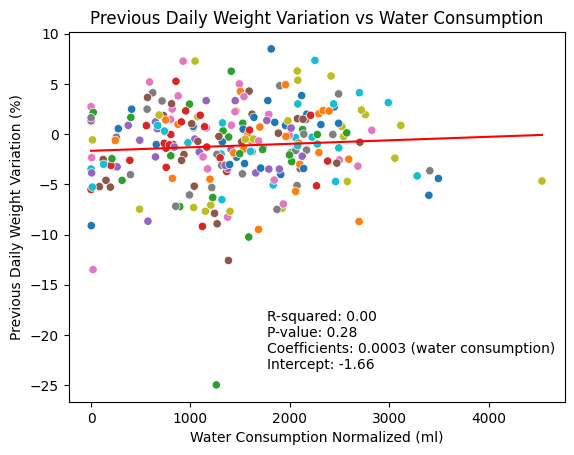

<Figure size 640x480 with 0 Axes>

In [153]:
# plot the correlation between daily weight variation and water consumption
sns.scatterplot(data=filtered_df, x='water_consumption_normalized', y='previous_daily_weight_variation', hue='subject')
# add a regression line using the model in the cell above
x_vals = np.linspace(filtered_df['water_consumption_normalized'].min(), filtered_df['water_consumption_normalized'].max(), 100)
y_vals = model.predict(sm.add_constant(x_vals))
plt.plot(x_vals, y_vals, color='red', label='Regression Line')
# add the statistics to the plot
plt.text(0.4, 0.25, f'R-squared: {model.rsquared:.2f}\n'
                     f'P-value: {model.f_pvalue:.2f}\n'
                     f'Coefficients: {model.params[1]:.4f} (water consumption)\n'
                     f'Intercept: {model.params[0]:.2f}', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
# set labels and title

plt.xlabel('Water Consumption Normalized (ml)')
plt.ylabel('Previous Daily Weight Variation (%)')
plt.title('Previous Daily Weight Variation vs Water Consumption')
#remove legend
plt.legend([], [], frameon=False)
plt.show()
# save figure as .pdf
plt.savefig('figures/hmv_previous_day_weight_variation_vs_water_consumed.pdf', bbox_inches='tight', transparent=True)